In [8]:
import numpy as np
import tensorflow.keras as ks
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import pydot
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [2]:
X_train.shape

(60000, 28, 28)

In [2]:
class DataPreprocessor:
    
    def __init__(self, X_train,X_test, Y_train, Y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        return
    
    def preprocess_data(self):
        self.X_train = self.X_train.reshape(60000,28,28,1)
        self.X_test = self.X_test.reshape(10000,28,28,1)
        return self
    
    def turn_output_data_to_categorical(self):
        self.Y_train = to_categorical(self.Y_train)
        self.Y_test = to_categorical(self.Y_test)
        return self
    
    def __getitem__(self):
        return self.X_train, self.X_test, self.Y_train, self.Y_test


        

In [3]:
data_preproc = DataPreprocessor(X_train, X_test, Y_train, Y_test)
data_preproc.preprocess_data().turn_output_data_to_categorical()

In [4]:
from random import randrange

i = randrange(len(X_test))
print(i)
data_preproc.X_test[i].shape

8756


(28, 28, 1)

In [6]:
type(ks.layers.Input(data_preproc.X_test[i].shape))

tensorflow.python.framework.ops.Tensor

In [31]:
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D,Input

def create_branch_of_network(image_shape):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=10, activation='relu', input_shape=image_shape))
    model.add(MaxPool2D(pool_size=2,strides=2))
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2,strides=2))
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2,strides=2))
    model.add(Conv2D(256, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))
    return model

def create_siamese_network(image_shape):
    
    #input images tensors
    image_one = ks.Input(image_shape)
    image_two = ks.Input(image_shape)
    #print(image_shape)
    #CNN
    model_1 = create_branch_of_network(image_shape)
    model_2 = create_branch_of_network(image_shape)
    
    #Siamese networks predictions
    y_hat_one = model_1(image_one)
    y_hat_two = model_2(image_two)
        
    #Adding layer to compute siaemese networks distance
    distance_computation = ks.layers.Lambda(lambda tensors: ks.backend.abs(tensors[0] - tensors[1]))
    images_distance = distance_computation([y_hat_one, y_hat_two])
    
    #Dense layer
    y_hat = Dense(1, activation = 'sigmoid')(images_distance)
    
    #inputs & outputs
    siamese_net = ks.Model(inputs= [image_one, image_two], outputs = y_hat)
    
    return siamese_net,

In [27]:
random_image_shape_celeb = np.random.rand(218, 178, 3)
random_image_shape_celeb.shape

(218, 178, 3)

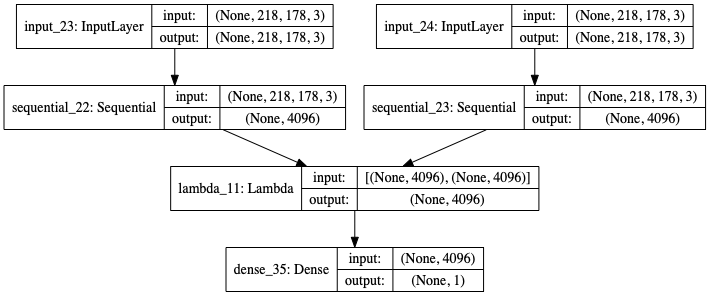

In [32]:
import pydot
siamese_net = create_siamese_network(random_image_shape_celeb.shape)
plot_model(siamese_net, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [35]:
#With MNist it won't work with the whole architecture as the images are too small
model = create_siamese_network((218, 178, 3))

optimizer = ks.optimizers.Adam(lr = 0.00006)

model.compile(loss = 'binary_crossentropy', optimizer = optimizer)